# <center>Forecasting Fuel Moisture Content with Deep Learning</center>
<center>Math Clinic Fall 2021 - MATH4779</center>
<center>University of Colorado Denver</center>
<center>Authors: Brian Zhang, Dan Line-Bell, Karina Fisher, Leo Brossart</center>
<center>Advisor: Jan Mandel</center>
<center>Date: December 8th, 2021</center>
---


## <center>Abstract</center>
---
Coupled atmosphere-fire models capable of predicting fire spread in realtime are of concern in todays research and industry. The Weather Research and Forcasting (WRF) model and the SFIRE fire-spread model have been coupled to produce WRF-SFIRE. The fuel moisture model within WRF-SFIRE predicts fuel mositure content for each node in the fire-model mesh using a time-lag first order differential equation with assimilation of station data [[1]](#references). Here we present an alternative method that utilizes TensorFlow deep learning models, that are single-step and multi-step, to forecast fuel moisture content for a given time interval. 

<a href='https://github.com/danline-bell/4779f21/blob/main/WRF-SFIRE%20diagram.jpg'><center><img src='https://raw.githubusercontent.com/danline-bell/4779f21/main/images/WRF-SFIRE%20diagram.jpg' width=500></img></center></a>

## <center>Table of Contents</center>
---

<center>

**1 [Introduction](#introduction)**

**2 [Technical Background](#background)**

2.1 [Brief Intro to Deep Learning](#introdeep)

2.1.1 [Cost Functions](#costfunction)

2.1.2 [Linear Model](#linearmath)

2.2 [Recurrent Neural Network Model](#rnn)
 
2.2.1 [Recurrent Neural Networks (RNNs)](#rnnmath)

2.2.2 [Long Short-Term Memory (LSTM)](#lstmmath)

2.3 [Gradient Descent & Bakcpropagation (Reverse-Mode Autodiff)](#gradients)

2.3.1 [Stochastic Gradient Descent](#stochastic)

2.3.2 [Gradient of Linear Regressiong](#LR)

2.3.3 [LSTM Gradients](#LSTM)

**3 [Materials & Methods](#methods)**

3.1 [Data Acquisition](#acquisition)

3.2 [Cleaning Up the Data](#cleaning)

3.3 [Looking at the Data](#looking)

3.4 [Inspection, Further Clean up, and Feature Engineering](#inspection)

3.5 [Splitting and Normalizing the Data](#splitting)

3.6 [Data Windowing](#window)

**4 [Results](#results)**

4.1 [Linear Model](#linearmodel)

4.2 [Recurrent Neural Network Model](#rnnmodel)

4.3 [Multi-Step Linear Model](#multilinear)

4.4 [Multi-Step RNN Model](#multirnn)

**5 [Conclusion](#conclusion)**

**[Author Contributions](#contributions)**

**[Acknowledgements](#acknowledge)**

**[References](#references)**
</center>



## <a name='introduction'><center>1 Introduction</center></a>
---
Tensorflow is the most popular machine learning and deep learning (DL) framework in 2021. It is capable of building, training, and testing models in a couple lines of code. We will be using Tensorflow to build and evaluate Neural Network (NN) models to predict fuel moisture content based on previous moisture contents and atmospheric conditions. This will be used to provide an alternative model to the fuel moisture content ODE in the WRF-SFIRE model [[1]](#references). 

First, we are going to provide certain time windows (e.g. 24 or 48 hours) of atmospheric data (temperature, precipatation, dew point, etc) and moisture data (RAWS stations) to the network and try to get it to forecast fuel moisture for a certain time window into the future (e.g. 1 or 24 hours) from atmospheric data only. Our inputs will be the atmospheric data ($T$, $pcp$, $dp$, ...) and moisture $m$ while our labels and output will be moisture as well. We will create single-step (forecast is a single hour) and multi-step (forecast is multiple time steps) model for this problem. The Tensorflow tutorial discusses multiple types of multi-shot models but the best performer (for the tutorial) are single-shot models which make the entire sequence prediction in a single step [[4]](#references). Thus, we should expect the same models to perform best for our problem as well. We will begin by talking about NNs in general, see [[3]](#references) for more information.

In [ ]:
#Setting up our environment
import pandas as pd
import numpy as np
from IPython.display import YouTubeVideo
import json
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import IPython
import IPython.display
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## <a name='background'><center>2 Technical Background</center></a>
---

### <a name='introdeep'><center>2.1 Brief Intro to Deep Learning</center></a>
At the center of deep learning is the Artificial Neural Network (ANN), which is a computer algorithm modeled after the biological neurons in the brain. This work started with the development of the *Perceptron* . Given some input vector $\mathbf x = (x_1, x_2, ..., x_n)$, weight vector $\mathbf w = (w_1, w_2, ..., w_n)$, bias term $b$,  and activation function $a(z)$ also called step functions, where, 

$$z = \mathbf w^T \cdot \mathbf x + b = b + w_1x_1 + w_2x_2 +...+ w_nx_n$$

we can express the output of the percpetron as the following:

$$h_w(\mathbf z) = a(\mathbf w^T \cdot \mathbf x + b)$$
This idea is illustrated in Figure 1 below,
<br><a href="https://towardsdatascience.com/what-the-hell-is-perceptron-626217814f53"><center><img src="https://raw.githubusercontent.com/danline-bell/4779f21/main/images/perceptron.png" width=400></img></center></a><center>Figure 1: Single layer perceptron</center>

We will often refer to our input data vectors as *features*  and there have been many activation functions developed, one of the most common being the Rectified Linear Unit (ReLU) which can be seen in Figure 2 below. 

<br><a href="https://medium.com/@shrutijadon10104776/survey-on-activation-functions-for-deep-learning-9689331ba092"><center><img src="https://raw.githubusercontent.com/danline-bell/4779f21/main/images/activation_functions.png" width=400></img></center></a><center>Figure 2: Common activation functions</center>

#### <a name='costfunction'><center>2.1.1 Cost Functions</center></a>
In order for a neural network to learn, it has to be told whether its doing good or bad at predicting the outputs from the data. In supervised learning, this is achieved through a *cost (loss) function*. The cost function essentially computes a cost between what the model is predicting and the label given in the data. The most common cost function is the Mean Squared Error (MSE) cost function. The goal of the learning process is minimize the cost function over several iterations of training.

#### <a name='linearmath'><center>2.1.2 Linear Model</center></a>
$$ Y=b_0+b_1X_1+\cdots+b_nX_n+e$$

Here, $e$ is the random error. Assume
$$E(e)=0, 0<\text{Var}(e)=\sigma^2<\infty,$$
where the error variance $\sigma^2$ is unknown.

Now $N$ independent observations of the variables $X$, $Y$ in the model are made to obtain the samples: $(X_1,Y_1),\cdots,(X_N,Y_N)$. According to the linear model, these samples can be described by
$$ Y_i=b_0+b_1X_{1i}+\cdots+b_nX_{ni}+e_i, i=1,\cdots,N$$
Here $e_i$ is the value of the random error $e$ at $i^{th}$ observation, which is not observable. We assume
$e_1, \cdots, e_N$ are independent and identically distributed, and
$$E(e_i)=0, 0<\text{Var}(e_i)=\sigma^2<\infty$$

Now we use $a_0, a_1, \cdots, a_n$ to estimate $b_0, b_1, \cdots, b_n$. At $(X_{1i},\cdots, X_{ni})$, the dependent variable $Y$ is predicted to be
$$\hat{Y}_i=a_0+a_1X_{1i}+\cdots+a_nX_{ni}, i=1,\cdots,N$$

We want to minimize

$$Q(a_0,a_1,\cdots,a_n)=\sum^N_{i=1}(Y_i-\hat{Y}_i)^2$$
$$=\sum^N_{i=1}(Y_i-a_0-a_1X_{1i}-\cdots-a_nX_{ni})^2$$
 

### <a name='rnn'><center>2.2 Recurrent Neural Network Model</center></a>

#### <a name='rnnmath'><center>2.2.1 Recurrent Neural Networks (RNNs)</center></a>

RNNs process a time series step-by-step and maintains an internal state between each time-step. The RNN layer used in our model is Long Short-Term Memory (tf.keras.layers.LSTM). 

The argument return_sequences (appearing in section 4 of this notebook) configures the layer to return an output for each input. This allows the model to stack RNN layers, train on multiple time-steps simultaneously, and train on a given time interval of past data (e.g. 24 hours). 

<a href='https://github.com/danline-bell/4779f21'><center><img src='https://raw.githubusercontent.com/danline-bell/4779f21/main/images/rnn_layers.png'></img></center></a>

The figure above represents a single Keras RNN layer with `return_sequences=True`. The width of each layer is 24 hours. `Inputs` represents all model inputs . `Model` represents a single `tf.keras.layers.LSTM`. `Predictions` represents the predictions made by the model for each time within a time interval. Lastly, `Labels` represents the labels assigned to each output. Notice that the model keeps an *internal state*  which needs to be given `Inputs` as well as the output from the previous time step so that it can learn the best relationship between inputs and outputs.

When working with time series DL models, there is technically no separate 'input' and 'output' features (only "time" and "values"). Meaning the inputs can be used as simply inputs, simply labels, or both as mentioned in the TensorFlow Tutorial [[3]](#references) (at the start of the data windowing section) and this <a href='https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/'>machine learning blogpost</a>. In this notebook, we are using fuel moisture as both an input and output *during the training* but *no* input during the validation and testing.

#### <a name='lstmmath'><center>2.2.2 Long Short-Term Memory (LSTM)</center></a>

Long Short-Term Memory (LSTM) networks are a modified version of RNNs with good performance in describing the temporal dynamics of time series data, such as dead fuel moisture content (DFMC) [10].
<center><a href="https://github.com/danline-bell/4779f21"><img src='https://raw.githubusercontent.com/danline-bell/4779f21/main/images/lstm.png'></img></a>


There are three gate controllers used to determine what information should be forgotten in the LSTM unit: input ($Z^i$), forget ($Z^f$) and output gates ($Z^o$).  The basic LSTM unit requires the current input vector $X_t $, its previous cell state $C_{t-1}$ and the previous hidden state $h_{t-1}$. The initial values are $C_0=0$ and $h_0=0$. These three gates are obtained as:

$$Z^i=σ(W_x^i X_t+W_h^ih_{t-1}+b^i)$$
$$Z^f=σ(W_x^f X_t+W_h^f h_{t-1}+b^f)$$
$$Z^o=σ(W_x^o X_t+W_h^o h_{t-1}+b^o)$$

where $σ$ is the nonlinear activation function, usually the sigmoid function:

$$σ(x)=\frac{1}{1+e^{-x}} $$

Except for these three gates, another intermediate state $Z$ is calculated as:

$$Z=\tanh⁡{(W_x X_t+W_h h_{t-1}+b)}$$

Then, the memory cell ($C_t$) and hidden state ($h_t$) of this LSTM are updated as:

$$C_t=Z^f∘C_{t-1}+Z^i∘Z$$
$$h_t=Z^o∘\tanh⁡{C_t}$$

where the operator $∘$ denotes the Hadamard product (element-wise product). 

Therefore, $y_t$ can be obtained as:

$$y_t=σ(W_h^y h_t+b^y)$$

### <a name='gradients'><center>2.3 Gradient Descent & Backpropagation (Reverse-Mode Autodiff)</center></a>

Let $\mathbf{a}=<a_0, a_1, \cdots, a_n>$

Given that we want to minimize $\text{MSE}(\mathbf{a})$, we want to change or update
$\mathbf{a}$ such that $\text{MSE}(\mathbf{a})$ reduces. 

We know that the gradient vector $\nabla \text{MSE}(\mathbf{a})$ points in the direction of the greatest increase of $\text{MSE}(\mathbf{a})$ at $\mathbf{a}$. Thus, it follows that setting the direction $-\nabla \text{MSE}(\mathbf{a})$ would achieve our desired objective. This
leads to a simple iterative algorithm as follows:

Input: $\alpha$, $n$

Initialize $\mathbf{a}$ to a random value.

For $n$ steps do:

Update $\mathbf{a} = \mathbf{a} - \alpha \nabla \text{MSE}(\mathbf{a})$

Output: $\mathbf{a}$

Repeat until convergence

#### <a name='stochastic'><center>2.3.1 Stochastic Gradient Descent</center></a>

In this approach, only a single example from the whole training set $\mathbf{X}$ is used in the update step. Note that the example we use in each iteration is different and randomly chosen. Two other points about this algorithm are worth noting. First, it runs much faster than the ordinary gradient descent method as it requires a computation of the gradient over only a single example.
Second, the update direction is not as accurate as we are only using a very small fraction of the training dataset.

#### <a name='LR'><center>2.3.2 Gradient of Linear Regression</center></a>

MSE cost function for a Linear Regression model
$$\text{MSE}(\mathbf{a})=\frac{1}{N}\sum_{i=1}^{N}(\mathbf{a}^T \cdot\mathbf{X}_i-Y_i)^2$$

Partial derivatives of the cost function:
$$ \frac{\partial}{\partial a_{j}}\text{MSE}(\mathbf{a})=\frac{2}{N}\sum_{i=1}^{N}(\mathbf{a}^T \cdot\mathbf{X}_i-Y_i)X_{ji} $$

Gradient vector of the cost function:#
$$ \nabla_\mathbf{a} \text{MSE}(\mathbf{a})=\begin{pmatrix} \frac{\partial}{\partial a_{0}}\text{MSE}(\mathbf{a}) \\ \frac{\partial}{\partial a_{1}}\text{MSE}(\mathbf{a}) \\ \vdots \\\ \frac{\partial}{\partial a_{n}}\text{MSE}(\mathbf{a}) \end{pmatrix}=\frac{2}{N}\mathbf{X}^T \cdot (\mathbf{X} \cdot \mathbf{a}-\mathbf{Y})$$

#### <a name='LSTM'><center>2.3.3 LSTM Gradients</center></a>

We compute the prediction error E(k) and use the Back Propagation Through time algorithm to compute the gradient

$$ \frac{\partial E}{\partial W}=\sum_{t=1}^T \frac{\partial E_t}{\partial W} $$

Using gradient descent algorithm, the parameters $W$ are updated by

$$ W \leftarrow W-\alpha \frac{\partial E}{\partial W} $$

The gradient of the error on the $k$ time step is given by:
$$ \frac{\partial E_k}{\partial W}= \frac{\partial E_k}{\partial h_k} \frac{\partial h_k}{\partial C_K} \cdots \frac{\partial C_2}{\partial C_1}\frac{\partial C_1}{\partial W} =\frac{\partial E_k}{\partial h_k} \frac{\partial h_k}{\partial C_K} (\prod_{t=2}^k \frac{\partial C_t}{\partial C_{t-1}}) \frac{\partial C_1}{\partial W}  $$

In an RNN,
$$C_t=σ(W_{rec} \cdot C_{t-1}+ W_{in} \cdot C_{t})$$

\begin{align}
\frac{\partial C_t}{\partial C_{t-1}}=&σ'(W_{rec} \cdot C_{t-1}+ W_{in} \cdot C_{t})\cdot \frac{\partial}{\partial C_{t-1}}(W_{rec} \cdot C_{t-1}+ W_{in} \cdot C_{t}) \\
 =&σ'(W_{rec} \cdot C_{t-1}+ W_{in} \cdot C_{t})\cdot W_{rec}
\end{align}

We have:

$$ \prod_{t=2}^k σ'(W_{rec} \cdot C_{t-1}+ W_{in} \cdot C_{t})\cdot W_{rec} \rightarrow 0 $$

So

$$\frac{\partial E_k}{\partial W} \rightarrow 0 $$

for large time step k.

The network’s weights update will be:

$$W \leftarrow W-\alpha \frac{\partial E}{\partial W} \approx W $$

So no significant learning will be done in reasonable time.

In an LTSM,
$$C_t=Z^f∘C_{t-1}+Z^i∘Z$$
or
$$C_t=σ(W^f \cdot [X_t,h_{t-1}]+b^f)∘C_{t-1}+σ(W^i \cdot [X_t,h_{t-1}]+b^i)∘\tanh(W \cdot [X_t,h_{t-1}]+b)$$

Notice that the state vector $C_t$ is a function of $C_{t-1}$, $Z^f$, $Z$, $Z^i$, which should be taken into account when computing the derivative during backpropagation.

\begin{align}
  \frac{\partial C_t}{\partial C_{t-1}}= &\frac{\partial}{\partial C_{t-1}}[Z^f∘C_{t-1}+Z^i∘Z] \\
=&\frac{\partial}{\partial C_{t-1}}[Z^f∘C_{t-1}]+\frac{\partial}{\partial C_{t-1}}[Z^i∘Z] \\
=& \frac{\partial Z^f}{\partial C_{t-1}} \cdot C_{t-1}+\frac{\partial C_{t-1}}{\partial C_{t-1}} \cdot Z_f+\frac{\partial Z^i}{\partial C_{t-1}} \cdot Z+\frac{\partial Z}{\partial C_{t-1}}\cdot Z^i
\end{align}

One can calculate the four derivative terms and obtain
$$\frac{\partial C_t}{\partial C_{t-1}}=A_t+B_t+C_t+D_t$$
where $A_t$, $B_t$, $C_t$, and $D_t$ can be found in [6].

Plugging this into the gradient of the error on the $k$ time step,

$$ \frac{\partial E_k}{\partial W}=\frac{\partial E_k}{\partial h_k} \frac{\partial h_k}{\partial C_K} (\prod_{t=2}^k (A_t+B_t+C_t+D_t)) \frac{\partial C_1}{\partial W}  $$

Suppose for some time step $k<T$, we have
$$\sum_{t=1}^k\frac{\partial E_k}{\partial W} \rightarrow 0 $$

The presence of the forget gate’s vector of activations in the gradient term allows the LSTM to find a suitable parameter update of the forget gate at time step $k+1$ such that:
$$\frac{\partial E_{k+1}}{\partial W} \nrightarrow 0 $$
which preventing the error gradients from vanishing.

## <a name='methods'><center>3 Materials & Methods</center></a>
---

### <a name='acquisition'><center>3.1 Data Acquisition</center></a>

Our file will consist of the variables temperature, dew point temperature, precipitation, wind speed, wind direction, relative humidity, fuel moisture and a date and time column. The date and time column will be removed from the dataframe below as we will run our variables against time.

In [ ]:
# Reading the json as a dict from github
url = 'https://raw.githubusercontent.com/danline-bell/4779f21/main/data/datafix.json'
df = pd.read_json(url, orient='split')

# remove date and time data
date_time = pd.to_datetime(df.pop('date and time'), format='%Y-%m-%d %H:%M:%S')

### <a name='cleaning'><center>3.2 Cleaning Up the Data</center></a>

To fix all the erroneous values for precipitation we used the following code: 

In [ ]:
'''
precip = df['precipitation']

bad_precip = precip == 9999.000000  # erroneous value

precip[bad_precip] = 14.6232199643  # realistic maximum value'''

"\nprecip = df['precipitation']\n\nbad_precip = precip == 9999.000000  # erroneous value\n\nprecip[bad_precip] = 14.6232199643  # realistic maximum value"

The RTMA files gave us the data on Temperature, Dew Point Temperature, Precipitation, Wind Speed and Wind Direction. We also set up the same formula for Relative Humidity used from the wrfxpy code[9],  to be calculated for each observation.

These files were made every hour for every day from May 18th, 2018 to May 30th, 2020. Throughout these files, there were a number of hours missing where we needed to fill in the data somehow.

To fill in the missing values, we used a package called Datawig. Datawig learns Machine Learning models to impute missing values in tables or in our case, our dataframes with the missing data from the RTMA files.[7]

Datawigs useful feature that we are using here is the SimpleImputer class. The SimpleImputer takes your input columns from the dataframe, and builds an imputed column of the chosen variable based off the output column chosen in the code. [8]

We took each feature against all the other features in our dataframe besides date and time. We used the imputed entries for each of the following variables to fill in the missing values in our current dataframe: temperature, dew point temperature, precipitation, relative humidity, wind speed and wind direction. 

Example of Datawig SimpleImputer:

In [ ]:
'''
#Initialize a SimpleImputer model for temperature
imputer1 = datawig.SimpleImputer(
    #columns containing the information about the column we want to impute
    input_columns=['fuel_moisture', 'dew_point','precipitation', 'relative_humidity','wind_speed', 'wind_direction'],
    #the column we would like to impute values for
    output_column='temp',
    #stores model data and metrics
    output_path = 'imputer_model'
)

#Fit an imputer model on the train data
imputer1.fit(train_df=df)'''

"\n#Initialize a SimpleImputer model for temperature\nimputer1 = datawig.SimpleImputer(\n    #columns containing the information about the column we want to impute\n    input_columns=['fuel_moisture', 'dew_point','precipitation', 'relative_humidity','wind_speed', 'wind_direction'],\n    #the column we would like to impute values for\n    output_column='temp',\n    #stores model data and metrics\n    output_path = 'imputer_model'\n)\n\n#Fit an imputer model on the train data\nimputer1.fit(train_df=df)"

Example output of Datawig SimpleImputer

In [ ]:
'''
predictions1 = imputer1.predict(df) #creates dataframe with 'imputed temp' column

predictions1'''

"\npredictions1 = imputer1.predict(df) #creates dataframe with 'imputed temp' column\n\npredictions1"

<a href="https://github.com/danline-bell/4779f21"><center><img src='https://raw.githubusercontent.com/danline-bell/4779f21/main/images/datawig_table.png'></img></center></a>

We can see it created the 'temp imputed' column. We then put the values for any Nan's in the temp column to be filled in with temp imputed value using the following code. We did this for each of the variables from the RTMA files.

In [ ]:
'''df['temp'].fillna(value=predictions1.temp_imputed, inplace=True)'''

"df['temp'].fillna(value=predictions1.temp_imputed, inplace=True)"

### <a name='looking'><center>3.3 Looking at the Data</center></a>

It is hard to look at a dataframe to see all the observations from our data, so we will plot all our inputs over time for a 'bigger picture' view.

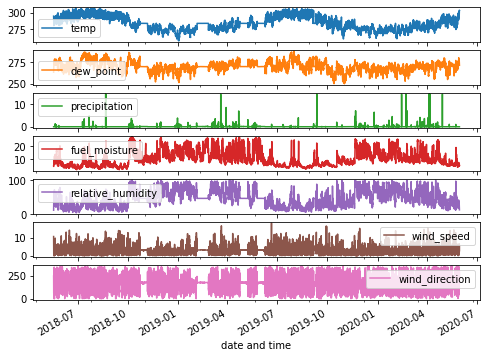

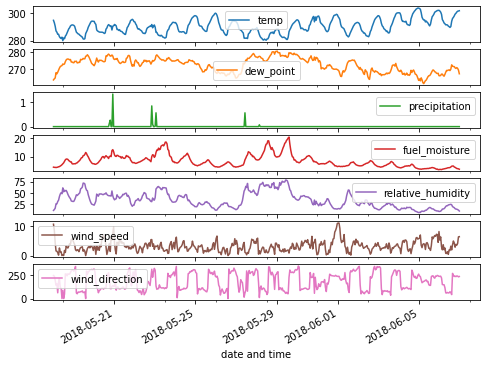

In [ ]:
#This will plot our data over time

plot_cols = ['temp', 'dew_point', 'precipitation', 'fuel_moisture', 'relative_humidity', 'wind_speed', 'wind_direction']
plot_features = df[plot_cols]
plot_features.index = date_time #df['date_time']
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480] #df['date_time'][:480]
_ = plot_features.plot(subplots=True)

In the first set of graphs above, all the parts that look relatively flat are the imputed values. They are not constant but they are not changing much in value. 

The reason for filling the missing values is because our methods will not execute with empty values. This was a simple imputer method and a more complex imputer method could change the relatively constant observations that are being imputed. 

### <a name='inspection'><center>3.4 Inspection, Further Clean up, and Feature Engineering</center></a>

Now we will briefly look at some of the statistics of the data using df.describe() and check to see if there are any missing values or outliers. We'll also cast all of the features to type float since they are all currently type object. We will use df.astype() to cast the entire DF to type float. 

In [ ]:
df = df.astype(float, errors = 'raise')  # convert all DF objects to float
df.describe().transpose()  # get statistical summary

,count,mean,std,min,25%,50%,75%,max
temp,17822.0,283.655033,10.276494,256.807713,275.512257,283.489507,292.222745,306.818191
dew_point,17822.0,269.930680,5.648700,249.754623,266.503503,269.997111,273.265609,288.165748
precipitation,17822.0,0.052660,0.615625,0.000000,0.000000,0.000000,0.000000,14.623220
fuel_moisture,17780.0,10.332030,6.168294,1.600000,5.500000,8.600000,13.400000,27.200000
relative_humidity,17822.0,46.222916,23.678244,4.054425,25.952537,46.045185,64.232154,99.750206
wind_speed,17822.0,3.057064,2.097038,0.000000,1.656937,2.775949,3.791368,17.892921
wind_direction,17822.0,172.698135,80.831649,0.000000,109.869081,170.732564,237.526832,355.717814


The datawig imputation method was not used to fill in the missing values of Fuel Moisture as the data came from a different source and out of our 17,000+ obersavtions, only 42 were missing. The df.ffill command in pandas was used here to fill each missing observation of Fuel Moisture with the observation before it.

The inplace=True command replaces the missing value in our dataset with the observation before it.

In [ ]:
df.fuel_moisture.ffill(inplace=True)

It is common practice for the features to be "engineered" so that they are more readily fed as input to the DL models. We likely will need to transform the wind features similar to what is being done in [[4]](#references).

Lets look at the distribution of wind data:

Text(0, 0.5, 'Wind Speed [m/s]')

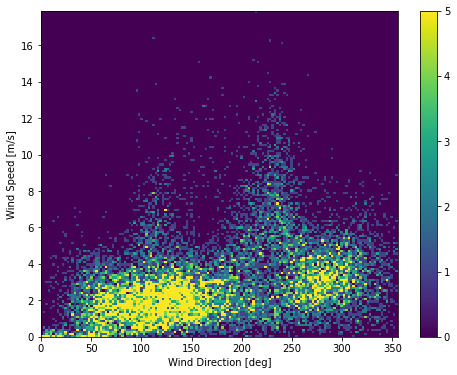

In [ ]:
plt.hist2d(df['wind_direction'], df['wind_speed'], bins=(150, 150), vmax=5)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Speed [m/s]')

DL models are generally sensitive to the formatting of the input data. In our case, representing the wind direction in degrees does not work well as model input. We'll convert the wind speed and direction into a combined wind vector `w_x` and `w_y`, and the we will plot the new wind distribution.

In [ ]:
wv = df.pop('wind_speed')
#max_wv = df.pop('max. wind_speed')

# Convert to radians.
wd_rad = df.pop('wind_direction')*np.pi / 180

# Calculate the wind x and y components.
df['w_x'] = wv*np.cos(wd_rad)
df['w_y'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
#df['max w_x'] = max_wv*np.cos(wd_rad)
#df['max w_y'] = max_wv*np.sin(wd_rad)

(-14.61909720500043, 8.801614065507652, -14.3060191099329, 15.206455902223514)

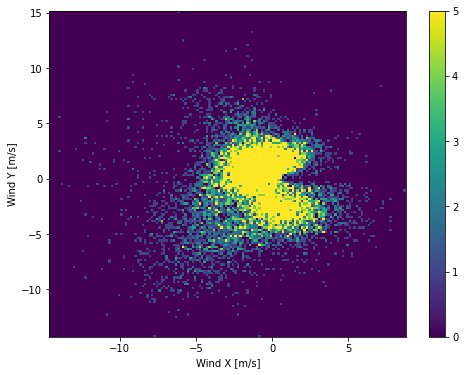

In [ ]:
plt.hist2d(df['w_x'], df['w_y'], bins=(150, 150), vmax=5)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

### <a name='splitting'><center>3.5 Splitting and Normalizing the Data</center></a>
---



One the most important procedures in machine learning is to split the dataset into training, testing, and validation sets. This allows to separate the data into "seeable" and "unseeable" sets so that the model doesn't overfit the data (although it could overfit in other ways if we are careless).

In [ ]:
#Splitting our data into training, validation and testing sets.

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]        #putting 70% into our training set
val_df = df[int(n*0.7):int(n*0.9)] #putting 20% into our validation set
test_df = df[int(n*0.9):]          #putting 10% into out testing set

# Note we also keep these sets in sequential order to ensure that the
# data goes into consecutive samples and that the validaiton and test sets
# are being evaluated after the model was trained.

num_features = df.shape[1]

Next we'll also need to convert the data into numpy arrays which will then be converted into a tensorflow dataset using `tf.data.dataset`. Neural networks often require our data to be scaled in some way. In this notebook we will rely on normalized data. That is, we are going to subtract the mean and divide by the standard deviation of each feature.

In [ ]:
train_mean = train_df.mean() #finding the mean of the training set
train_std = train_df.std()   #finding the standard deviation of the traing set

#Normalizing each set
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

We will plot our features to check for any obvious errors.

The violin plot will look at the distribution of the normalized features. This will plot how many standard deviations each observation is from the average value.

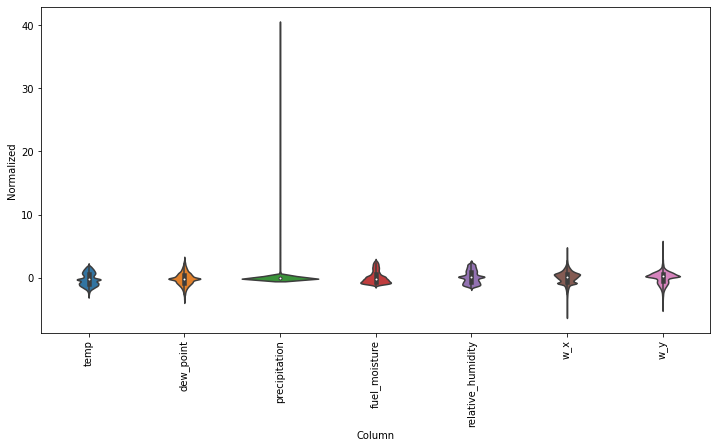

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Looking at the distribution of the features, precipitation has a long tail but nothing more than expected, and none of the other features have any obvious errors.

### <a name='window'><center>3.6 Data Windowing</center></a>

Data windowing refers to the creating a "window" around several time steps of the inputs and outputs that represents a given history and prediction interval. 

You can see a example of this in Figure 6 below: 

The input width is 24, which represents 24 hours of historical data that the model uses to predict a value. This includes the RTMA data and the fuel moisture data.

The offset is 24 hours, which dictates how far into the future the model will predict the value. 

The label width is set to 1, which represents the time interval width of the predicted value. Since we are predicting fuel moisture for 1 hour, fuel moisture is our label and has a time interval width of 1.
 
<a href="https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing"><center><img src="https://raw.githubusercontent.com/danline-bell/4779f21/main/images/window_example.png" width=500></img></center></a><center>Figure 6: Example of data windowing</center>


During training, the model takes a single window and minimizes the cost function, which is the mean squared error of the observed and predicted fuel moisture values. 

We will be implementing the data windowing to be used for all of the models. Most of the work is already given in the TensorFlow tutorial [[4]](#references). However, we will need to adapt it to our features and output.

In [ ]:
"""
Window Generator function
  input_width : time interval width in hours for historical data
  label_width : time interval width in hours for predicted value
  shift : how far into the future prediction is made
  label_columns : name of column to be predicted
"""

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Now that we have a window generator function, we can make two different options for our model to use. These data windows are flexible and can be generated with different configurations.

**For our single step models:**

The first option, w1, will be a window for a single prediction 24 hours in the future, given 96 hours of historical data. 

The other option, w2, will be a different window for a single prediction 1 hour in the future, given 6 hours of historical data. 

In [ ]:
#window 1: single prediction 24 hours in future given 96 hours of historical
w1 = WindowGenerator(input_width=96, label_width=1, shift=24,
                     label_columns=['fuel_moisture']) 
w1

Total window size: 120
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label indices: [119]
Label column name(s): ['fuel_moisture']

In [ ]:
#window 2: single prediction 1 hour in future given 6 hours of historical
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['fuel_moisture'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['fuel_moisture']

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 7)
Inputs shape: (3, 6, 7)
Labels shape: (3, 1, 1)


In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='fuel_moisture', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(24, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(1, max_n, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

Below is an plot of the 6 hour window. Across the x-axis, we can see the indices of the hours within the individual window. The blue lines represent the historical data used for the prediction, which includes the RTMA data and the observed fuel moisture data. The green circle represents the observed fuel moisture. 

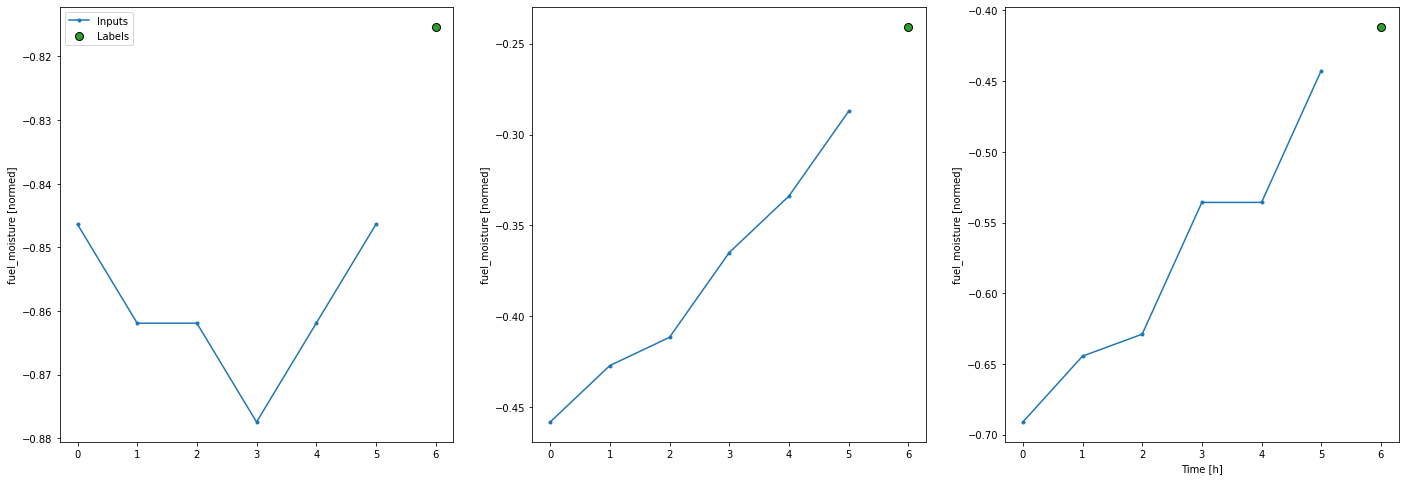

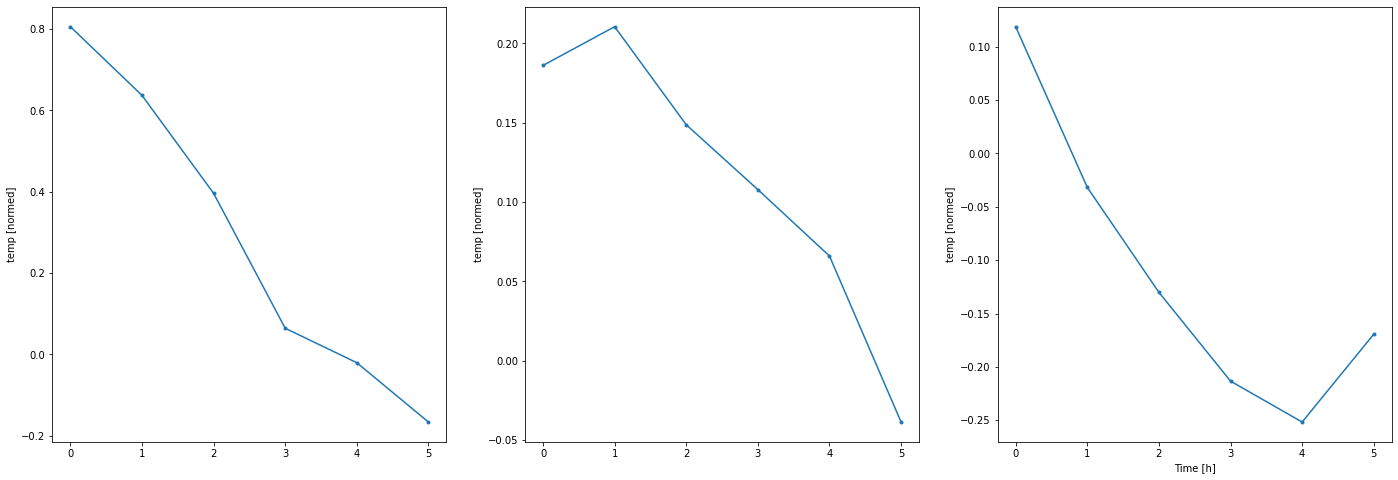

In [ ]:
w2.plot()
w2.plot(plot_col='temp')

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 7), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 7)
Labels shape (batch, time, features): (32, 1, 1)


## <a name='results'><center>4 Results</center></a>
---

### <a name='linearmodel'><center>4.1 Linear Model</center></a>

This will be our simplest trainable model. This model inserts a linear transformation between the input and output. The `tf.keras.layers.Dense` layer is the linear model and transforms the last axis of the data from (batch, time, inputs) to (batch, time, units). 

More specifically, `Dense` implements the operation `output = activation(dot(input, kernel) + bias)`. The `activation` is the elementwise activation function passed as the activation argument. The `kernel` is a weights matrix created by the layer. The `bias` is a bias vector created by the layer and is only applicable if the boolean operator `use_bias` is `True`. 

The activation function decides whether a neuron should be activated or not by calculating weighted sum and further adding bias with it. The purpose of the activation function is to introduce non-linearity into the output of a neuron. For a linear model, if no activation is specified, we get the activation function `a(x)=x`.




In [ ]:
#Configure a WindowGenerator object to produce these single-step (input, label) pairs

single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['fuel_moisture'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['fuel_moisture']

In [ ]:
#generates windows of 96 hours of consecutive inputs and labels at a time
#time axis acts as a batch axis
#each prediction made independently with no interaction between
wide_window = WindowGenerator(
    input_width=96, label_width=96, shift=1,
    label_columns=['fuel_moisture'])

wide_window

Total window size: 97
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]
Label column name(s): ['fuel_moisture']

In [ ]:
#tf.keras.layers.Dense with no activation set is a linear model
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 7)
Output shape: (32, 1, 1)


In [ ]:
#packaging the training procedure into a function
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
              metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
#train the model and evaluate its performance
history = compile_and_fit(linear, single_step_window)

val_performance = {}
performance = {}
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
390/390 [==============================] - 3s 6ms/step - loss: 1.2563 - mean_absolute_error: 0.8249 - val_loss: 0.6185 - val_mean_absolute_error: 0.5686
Epoch 2/20
390/390 [==============================] - 2s 5ms/step - loss: 0.3830 - mean_absolute_error: 0.4116 - val_loss: 0.2207 - val_mean_absolute_error: 0.3141
Epoch 3/20
390/390 [==============================] - 2s 6ms/step - loss: 0.1167 - mean_absolute_error: 0.2009 - val_loss: 0.0961 - val_mean_absolute_error: 0.2118
Epoch 4/20
390/390 [==============================] - 2s 6ms/step - loss: 0.0481 - mean_absolute_error: 0.1381 - val_loss: 0.0475 - val_mean_absolute_error: 0.1546
Epoch 5/20
390/390 [==============================] - 2s 5ms/step - loss: 0.0269 - mean_absolute_error: 0.1121 - val_loss: 0.0283 - val_mean_absolute_error: 0.1221
Epoch 6/20
390/390 [==============================] - 2s 6ms/step - loss: 0.0200 - mean_absolute_error: 0.0953 - val_loss: 0.0239 - val_mean_absolute_error: 0.1056
Epoch 7/20
390/3

Input shape: (32, 96, 7)
Output shape: (32, 96, 1)


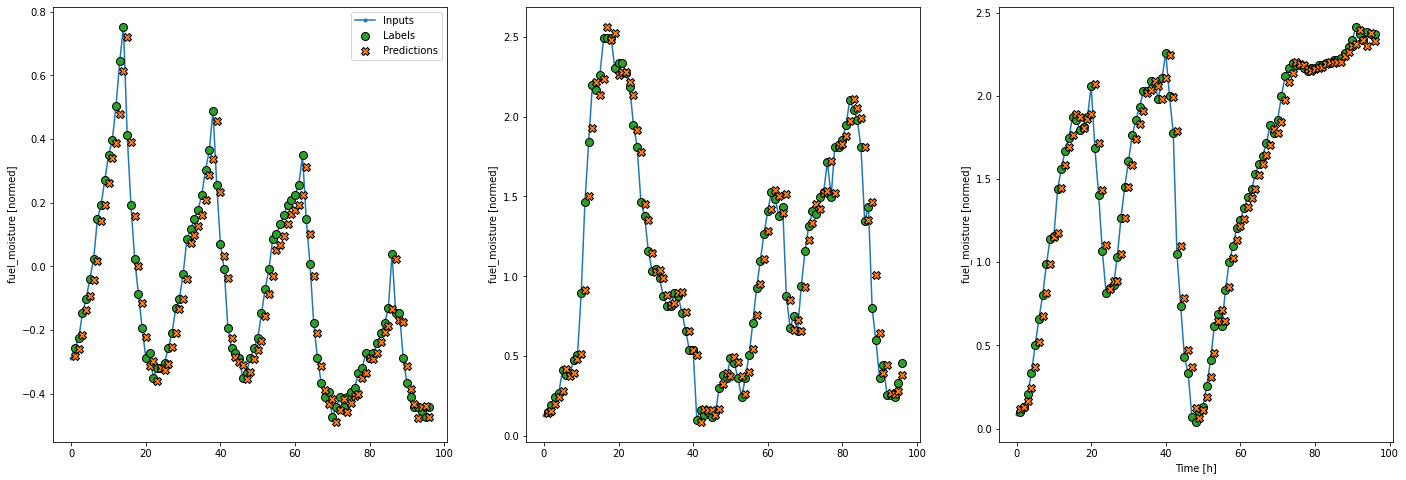

In [ ]:
#Linear Model Performance
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

wide_window.plot(linear)

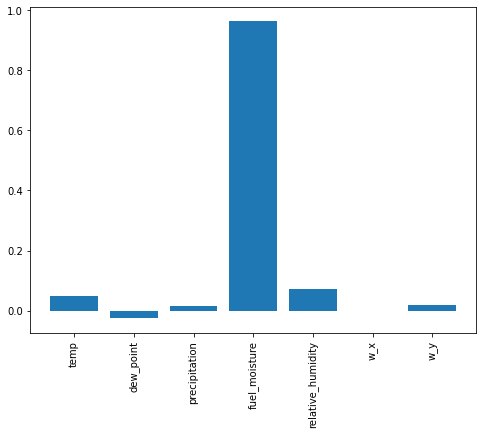

In [ ]:
#visualizing the layer's weight assigned to each input
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

As discussed in section 2.2.1 of this notebook, when working with time series DL models, there is technically no separate 'input' and 'output' features. Meaning the inputs can be used as simply inputs, simply labels, or both as mentioned in the TensorFlow Tutorial [[3]](#references) (at the start of the data windowing section) and this <a href='https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/'>machine learning blogpost</a>. The previous output is fed into the next timestep. Thus, it is not surprising the model is placing the most weight on the fuel moisture feature.

### <a name='rnnmodel'><center>4.2 Recurrent Neural Network Model</center></a>

Similar to our Linear Model, we will use layers with an activation function in our LSTM RNN. 

`Dense` implements the operation `output = tanh(dot(input, kernel) + bias)`. Recall, `input` is our RTMA data and observed fuel moisture data. The `kernel` is a weights matrix created by the layer. The `bias` is a bias vector created by the layer and is only applicable if the boolean operator `use_bias` is `True`. 

Since this is an RNN, we want the model to stack layers and train on multiple time-steps simultaneously. 

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True), #allows the model to stack RNN layers and train on multiple time-steps simultaneously
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 96, 7)
Output shape: (32, 96, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

109/109 [==============================] - 2s 18ms/step - loss: 0.0182 - mean_absolute_error: 0.0832


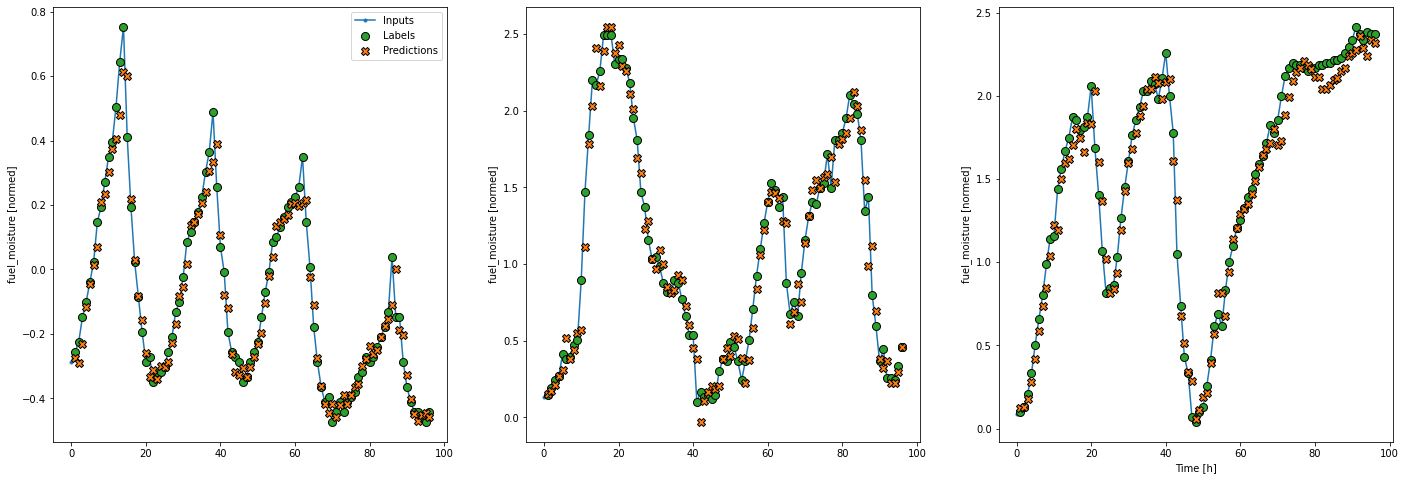

In [ ]:
#RNN performance
wide_window.plot(lstm_model)

**Performance results for the single-step models**

The validation set is used by the model during training to ensure that the model is performing in an acceptable manner. Once the model is trained, the test set is used to evaluate the models performance. 

As discussed throughout the notebook, our cost function is the Mean Squared Error of the observed and predicted fuel moisture values. 

From the performance graphs below, we can see that the error in both models decreased between the validation set and the test set. This shows that the model learned behavior which helped the model fine-tune its parameters and thus, its performance. 

The Linear Model performed comparably to the LSTM Model. The Linear Model is relatable to the WRF fuel-moisture prediction strategy in that the differential equation used by WRF is linear.  Our hypothesis was that the LSTM model would perform the best, which is the case for the single-step models. 



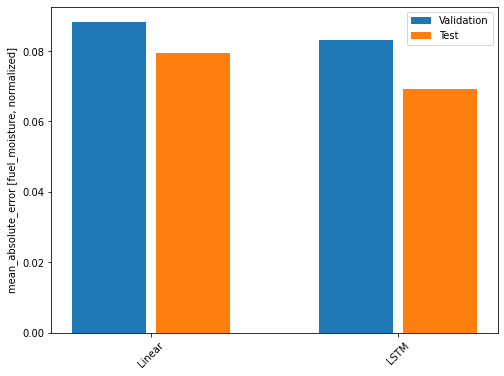

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [fuel_moisture, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Linear      : 0.0796
LSTM        : 0.0692


### <a name='multilinear'><center>4.3 Multi-Step Linear Model</center></a>

The previous models predicted single time step predictions. In the multi-step models we will look at expanding these models to make multiple time step predictions. In multi-step prediction models, the model will need to predict a range of future values. The models will predict all the features across all output time steps.

Here is a window object that generates these slices from the dataset:
The training data will predict Fuel Moisture Contents 24 hours into the future given 96 hours of data from our RTMA inputs(Temperature, Dew Point Temp, Precipitation, Relative Humidity and our wind vectors w_x and w_y) of the past.

Total window size: 120
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label indices: [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119]
Label column name(s): None

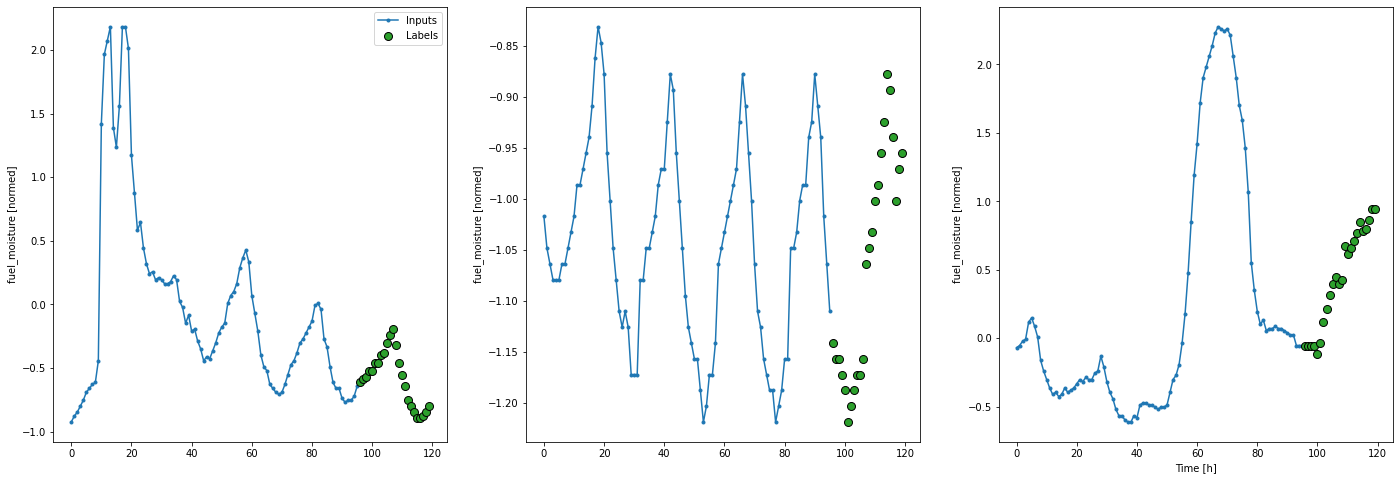

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=96,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

This Linear method will take a 'single-shot' approach where the model makes the entire sequence prediction in a single step. The model needs to predict OUTPUT_STEPS time steps from a single input time step with a linear projection. Unlike the previous method, the multi-step linear model will compare our 24 hours of predictions to the 24 hours of real data of Fuel Moisture.

The inputs are temperature, dew point temperature, precipitation, relative humidity, and the wind vectors w_x and w_y. The predictions will be what our model predicts the values of Fuel Moisture Contents to be given the trained model and the labels will the real Fuel Moisture values.

The picture below gives an example of this process but with only 24 hours of input.

<a href='https://github.com/danline-bell/4779f21'><center><img src='https://raw.githubusercontent.com/danline-bell/4779f21/main/images/linear_layers.png'></img></center></a>

The code below will train our model based off the inputs(temperature, dew point temperature, precipitation, relative humidity and the wind vectors w_x and w_y) and the labels(fuel moisture) given for a 96 hour period, and then make a prediction as to what are labels would be for the next 24 hours based upon the values of our inputs at that observation time.

This one specifically for the linear multi step model.

108/108 [==============================] - 0s 4ms/step - loss: 0.6135 - mean_absolute_error: 0.4280


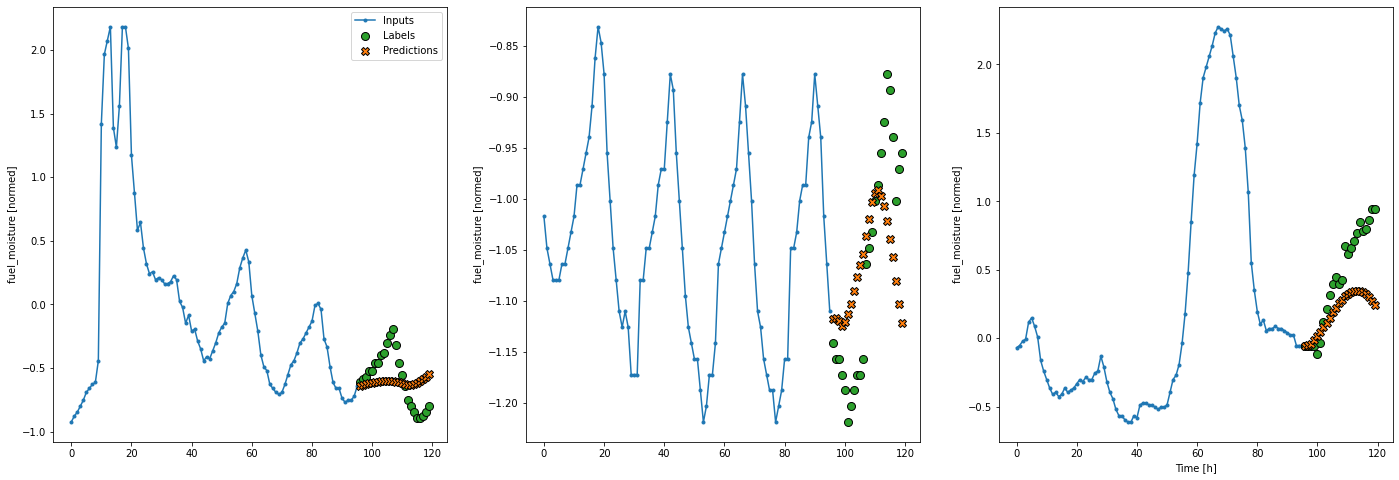

In [ ]:
MAX_EPOCHS = 30

multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance = {}
multi_performance = {}

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

### <a name='multirnn'><center>4.4 Multi-Step RNN Model</center></a>

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 96 hours, before making a single prediction for the next 24 hours.

The code below will train our model based off the inputs(temperature, dew point temperature, precipitation, relative humidity and the wind vectors w_x and w_y) and the labels(fuel moisture) given for a 96 hour period, and then make a prediction as to what are labels would be for the next 24 hours based upon the values of our inputs at that observation time.

This one specifically for the multi step RNN model.

108/108 [==============================] - 1s 12ms/step - loss: 0.6033 - mean_absolute_error: 0.4195


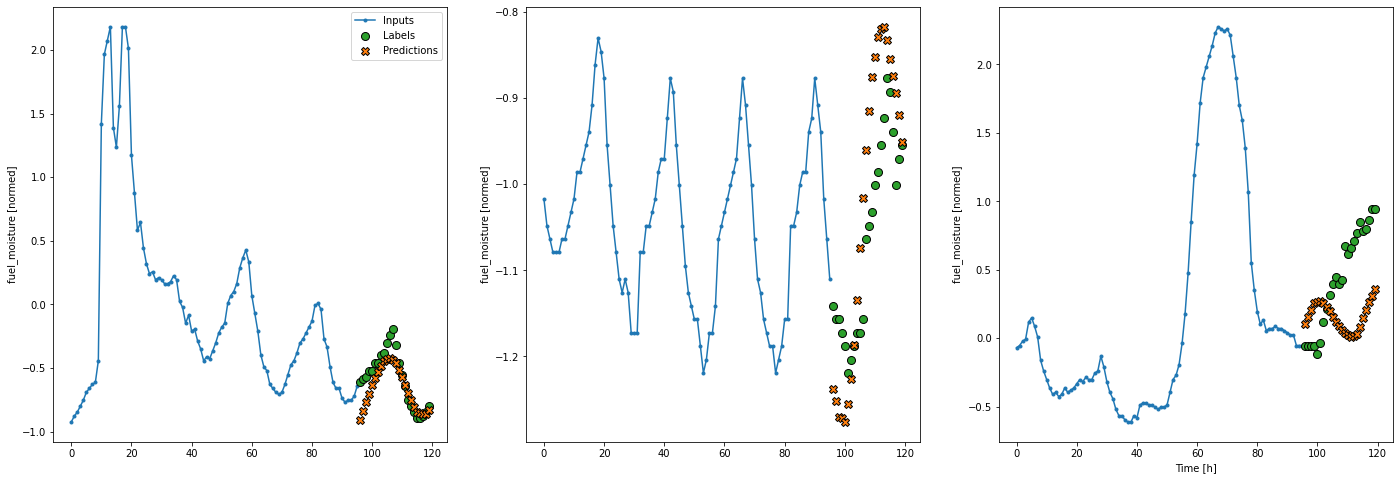

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

Performance Results for the multi-step methods

**Performance results for the multi-step models**

The validation set is used by the model during training to ensure that the model is performing in an acceptable manner. Once the model is trained, the test set is used to evaluate the models performance. 

As discussed throughout the notebook, our cost function is the Mean Squared Error of the observed and predicted fuel moisture values. 

From the graphs below, we can see that the error in both models increased from the validation set to the test set. This means that the models we trained couldn't generalize as well on the multi-step sequence. This could result from underfitting, overfitting, and/or information leak.

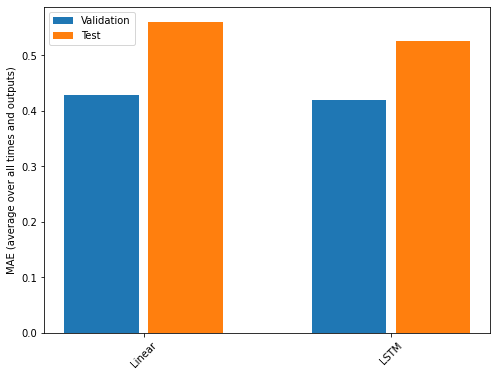

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Linear  : 0.5596
LSTM    : 0.5249


We were unable to prepare a quantitative comparison between our own models and the fuel moisture model in [[1]](#references). If given more time we, would determine what the exact comparison is. We would also be able fine tune the model architectures since there seems to be room for improvement. Additionally, the models were only trained using the ReLU activation function but there is reason to believe some other activation functions may perform better.

## <a name='conclusion'><center>5 Conclusion</center></a>
---

We have shown how to build, train, and test two machine learning models: a linear model and an LSTM RNN model. These were used to forecast fuel moisture both one hour and several hours into the future. 

## <a name='contributions'><center>Authors' Contributions</center></a>
---

BZ provided the code for the saturation ODE recreation in [[1]](#references), data acquisition, and contributed to the mathematical background to the ML models. DLB provided the code for the basic ODE recreation in [[1]](#references), data acquisition, and contributed to the code on the feature engineering and ML models. KF provided the code for the equilibrium ODE recreation in [[1]](#references), data aquisition, and contributed to the code on the window generator class and single-step machine learning models. LB provided the code for the saturation ODE in [[1]](#references), data acquisition, and contributed to the code on the data processing and multi-step models.

## <a name='acknowledge'><center>Acknowledgement</center></a>
---
This clinic is sponsored by the project <a href="https://appliedsciences.nasa.gov/what-we-do/projects/coupled-interactive-forecasting-weather-fire-behavior-and-smoke-impact-improved">"Coupled Interactive Forecasting of Weather, Fire Behavior, and Smoke Impact for Improved Wildland Fire Decision Making"</a> in the <a href="https://appliedsciences.nasa.gov/what-we-do/disasters">NASA DISASTERS</a> program. The authors would like to thank Jan Mandel for his support and efforts during the development of this project.

## <a name='references'><center>References</center></a>
---

**[1]** Mandel, J., Amram, S., Beezley, J. D., Kelman, G., Kochanski, A. K., Kondratenko, V. Y., Lynn, B. H., Regev, B., & Vejmelka, M. (2014). Recent advances and applications of WRF–SFIRE. Natural Hazards and Earth System Sciences, 14(10), 2829–2845. https://doi.org/10.5194/nhess-14-2829-2014<br>

**[2]** Vejmelka, M., Kochanski, A. K., & Mandel, J. (2016). Data assimilation of dead fuel moisture observations from remote automated weather stations. International Journal of Wildland Fire, 25(5), 558. https://doi.org/10.1071/wf14085 <br>

**[3]** Géron, A. (2017). Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (1st ed.). O’Reilly Media. <br>

**[4]** Time series forecasting | TensorFlow Core. (2021). TensorFlow. https://www.tensorflow.org/tutorials/structured_data/time_series<br>

**[5]** R. (2020, June 29). LSTM Gradients - Towards Data Science. Medium. https://towardsdatascience.com/lstm-gradients-b3996e6a0296<br>

**[6]** Arbel, N. (2020, May 16). How LSTM networks solve the problem of vanishing gradients. Medium. https://medium.datadriveninvestor.com/how-do-lstm-networks-solve-the-problem-of-vanishing-gradients-a6784971a577<br>

**[7]** Felix Biessmann, Tammo Rukat, Phillipp Schmidt, Prathik Naidu, Sebastian Schelter, Andrey Taptunov, Dustin Lange, David Salinas; 20(175):1−6, 2019.<br>

**[8]** https://datawig.readthedocs.io/en/latest/source/userguide.html#introduction-to-simpleimputer<br>

**[9]** Vejmelka, M., WRFXPY, (201-2016), GitHub repository, https://github.com/openwfm/wrfxpy/blob/829abe55c950840693dfae09adbb928ffdf3652a/src/rtma_cycler.py#L410

**[10]** Fan, C.; He, B. A Physics-Guided Deep Learning Model for 10-h Dead Fuel Moisture Content Estimation. Forests 2021, 12, 933. 
https://doi.org/10.3390/f12070933